In [ ]:
# This notebook is a copy similar to ALR_Client_Side found in:
# https://github.com/rfernand387/ALR_Earth_Engine/blob/master/ALR_Client_Side.ipynb

# Modifications have been made to accept an EE image with 10 m resolution bands that has been outputted from SL2P10_control.ipynb:
# https://github.com/kateharvey/Sentinel2_ALR/blob/main/shared/SL2P10_control.ipynb

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import ee
import json
from collections import OrderedDict
import time
import math
import csv
import os

# custom module
import ALR_functions as alr

In [2]:
ee.Authenticate()

Enter verification code:  4/1AX4XfWhclMzqE9xyPiSktpsaSYCmloJRWWk7yLokdSFRk2aK7Hg37leormc



Successfully saved authorization token.


In [3]:
# Authorize the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [4]:
# Set the test image using an uploaded asset for now
inputImageCollection = ee.ImageCollection('users/kateharvey/test_collection')
# inputImage = ee.Image(inputImageCollection.toList(inputImageCollection.size()).get(0))
inputImage = ee.Image('users/kateharvey/test_collection/20200801T155911_20200801T160644_T18TVQ_LAI')

# Change variable name here to match band name pattern (one of: Albedo, fAPAR, fCOVER, LAI, CCC, CWC, DASF)
outputName = 'LAI'
defaultBand = 'estimate'+outputName

# List the bands that we expect in the image (ensure number of bands in the list below matches the number bands in the input image)
# This is the order of bands produced by running SL2P10 and exporting the resulting ImageCollection
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'date', 'QC', 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'])

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [5]:
# Below we define a list of strings representing the expressions for each vegetation index as a function of the bands in the input image
# More vegetation indices can be defined, but the list CANNOT contain any two vegetation indices which are a linear combination of each
# other or LARs will fail to select the requested number of variables

# The formatting of the expression must be
# "<name of VI> = <expression with band names from inputImage_bands used as variables in the form b('<band name>')"

# Only include VIs that use 10 m bands (B2, B3, B4, B8)
input_VI_definition = ee.List(["RAW_B2  = b('B2')",
                               "RAW_B3  = b('B3')",
                               "RAW_B4  = b('B4')",
                               "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

In the following functions each input is recast to the expected data type as function parameter typing is not enforced in Earth Engine
when defining functions, and later methods called on these parameters within the function must recognize the type of the parameter
independently of other code

In [6]:
inputImage = alr.format_image(inputImage, inputImage_bands, defaultBand, input_VI_definition)

In [7]:
num_input_pixels = alr.get_num_pixels(inputImage)

In [8]:
scaledImage = alr.scale_image(inputImage, defaultBand)

In [9]:
select_features = alr.ee_LARS(scaledImage, defaultBand, 5, 10000)

In [10]:
# Creating the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
exportData = ee.batch.Export.table.toDrive(collection=alr.trim_data(image=inputImage, selected_features=select_features, response_band="estimateLAI", num_samples=50000, num_partitions=10),
                                           description="image_data_samples",
                                           fileFormat="CSV")

In [11]:
# Starting the export data task
exportData.start()

In [12]:
# Essentially a wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


In [13]:
# Reading the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/image_data_samples.csv')
X = trimmed_data.drop(labels=['LAI', 'system:index', '.geo'], axis=1)
y = trimmed_data.LAI

In [14]:
# We preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(sklearn.preprocessing.scale(X))

In [15]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(5, input_shape=[len(X.keys())]),
    tensorflow.keras.layers.Dense(4, activation="softsign"),
    tensorflow.keras.layers.Dense(3, activation="softsign"),
    tensorflow.keras.layers.Dense(2, activation="softsign"),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

2021-10-19 16:52:21.485862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Fitting the model to our trimmed data
LAI_model.fit(x = X.to_numpy(), y = y.to_numpy(), epochs = 100)

2021-10-19 16:52:21.668289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
1143/1143 [==============================] - 4s 2ms/step - loss: 0.6460 - mse: 0.6460 - mae: 0.5811
Epoch 2/100
1143/1143 [==============================] - 3s 2ms/step - loss: 0.0664 - mse: 0.0664 - mae: 0.1846
Epoch 3/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0465 - mse: 0.0465 - mae: 0.1642
Epoch 4/100
1143/1143 [==============================] - 3s 2ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1582
Epoch 5/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.1564
Epoch 6/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0403 - mse: 0.0403 - mae: 0.1525
Epoch 7/100
1143/1143 [==============================] - 2s 2ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1513
Epoch 8/100
1143/1143 [==============================] - 3s 3ms/step - loss: 0.0396 - mse: 0.0396 - mae: 0.1510
Epoch 9/100
1143/1143 [==============================] - 3s 3ms/step - loss: 0.0384 - mse: 0.0384 - mae:

In [17]:
# Predicting our own input data to evaluate the performance (for now)
LAI_predictions = pd.Series(LAI_model.predict(X.to_numpy()).flatten())

In [18]:
xy_tf_LAI = np.vstack([y, LAI_predictions])

In [19]:
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [20]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [21]:
rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

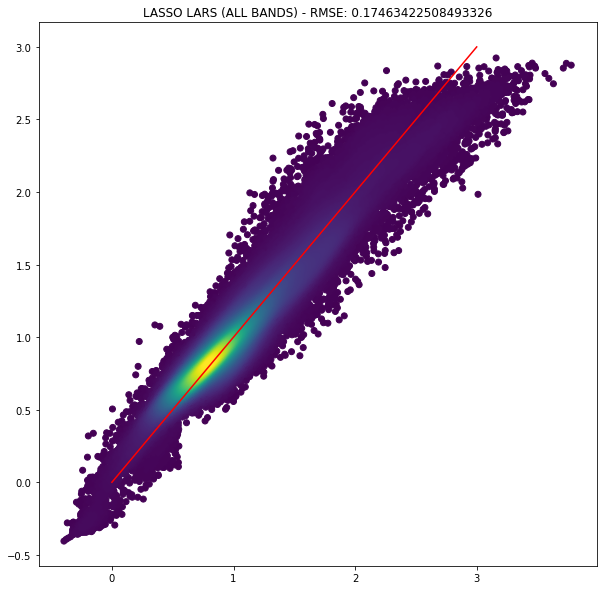

In [22]:
a_tf_LAI = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Using all features
ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.title.set_text('LASSO LARS (ALL BANDS) - RMSE: {}'.format(rmse_tf_LAI))

In [23]:
LAI_model.get_weights()

[array([[-0.5946455 ,  0.60888827, -0.03592872,  0.66304535, -0.31733522],
        [-0.3778874 ,  0.13090697, -0.2312796 ,  0.57659656,  0.9097157 ],
        [ 0.6589992 ,  0.44377792,  0.22984774,  0.25759932,  0.5363024 ],
        [ 0.07728553, -0.3818759 , -0.543906  ,  0.09094849, -0.11027889],
        [ 0.11546566, -0.31900507,  0.5741165 , -0.6439956 , -1.0552363 ]],
       dtype=float32),
 array([ 0.0908852 , -1.2879384 , -0.25072512, -0.15227427, -0.02810855],
       dtype=float32),
 array([[ 0.24423844, -1.0598286 , -0.11388014,  0.27727923],
        [ 0.3978359 , -0.429257  ,  1.1550797 , -1.787265  ],
        [ 0.29887396, -1.2004374 ,  0.48738304,  0.3878242 ],
        [-0.24367994,  0.4435086 , -0.21077923, -1.2864418 ],
        [ 0.09911841,  0.34690872,  0.08439013, -1.2302109 ]],
       dtype=float32),
 array([-0.00217913,  0.9655396 , -0.6164897 ,  0.45549506], dtype=float32),
 array([[ 1.1650966 ,  1.0258118 ,  0.9501202 ],
        [ 0.04641191,  0.77967566, -0.320237

In [24]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [25]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, LAI_model)[0])

0.65669715
0.656697429190129


In [26]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(LAI_model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)